# load data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import mstats

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error#, mean_absolute_percentage_error
import category_encoders

import lightgbm
import optuna

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', 500) 
# pd.set_option('display.max_colwidth', None)

# print multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
path = Path.joinpath(Path.cwd().parent / '1 Data', "011223_management_guidance.pkl")
df_raw = pd.read_pickle(path)

df_raw.head()
df_raw.shape

,quarter_guided,quarter_previous,date_guided,date_previous,actuals_announcement_date,guidance_annoucement_date,isin,firm_observations,firm_id,sic_division,fama_french_industry,firm_id_cat,sic_division_cat,fama_french_industry_cat,quarter_fama_industry_cat,year_fama_industry_cat,quarter_previous_cat,year_cat,actual_revenue,revenue_guidance_average,revenue_guidance_error_adjusted,revenue_guidance_range,revenue_guidance_error_previous_rel,analyst_mean_guidance_date,revenue_prev,revenue_prev2,revenue_prev3,revenue_prev3_change,revenue_prev2_change,ebit,ebitda,gross_profit,net_income,cogs,sga,depreciation_amortization,assets,cash_eq,receivables,liabilities,total_debt,total_equity,nwc,change_nwc,capex,free_cash_flow,cash_from_invest,cash_from_finance,cash_from_oper,marketcap,price_at_guidance,price_15days,price_40days,price_60days,price_180days,price_180days_change,price_60days_change,price_40days_change,price_15days_change,price_vola_3month,price_vola_6month,beta_russell_60days,short_interest_at_guidance,short_interest_15,short_interest_60,short_interest_180,short_interest_180_change,short_interest_60_change,short_interest_15_change,goodwill,operating_income,book_value_share,real_gdp_growth,ebit_margin,ebitda_margin,net_income_margin,roic_an,return_on_equity,cash_asset_ratio,nwc_assets,capex_assets_ratio,restructuring_charges_many_zeros,rd_many_zeros,selling_marketing_many_zeros,inventory_turnover_many_zeros,warranty_liablities_many_zeros,total_dividends_many_zeros,goodwill_impairment_many_zeros,restricted_cash_many_zeros,gain_on_sale_assets_many_zeros,gain_on_sale_invest_many_zeros,warranty_liabilities_many_zeros,asset_writedown_many_zeros,inventory_many_zeros,raw_materials_inventory_many_zeros,work_in_progress_inventory_many_zeros,finished_goods_inventory_many_zeros,change_in_inventories_many_zeros
3,2001Q4,2001Q3,2001-12-31,2001-09-30,2001-10-25,2001-12-19,US5184391044,33,1073,3,9,1073,3,9,2001Q49,20019,3,2001,1298.200,1272.226000,1253.693145,12.91600,-0.014567,1323.150,1194.800,1047.200,1103.500,0.082737,0.140947,152.900,190.600,845.500,76.500,349.300,692.600,37.700,3300.500,157.400,794.100,1524.800,430.900,1775.700,785.500,244.200,-50.100,-165.41250,-58.000,-38.600,-104.400,7914.22921,15.99501,16.65000,13.12443,16.98001,20.30001,-0.212069,-0.058009,0.218720,-0.039339,32.7232,31.1500,1.02641,2.48016,2.48016,2.45677,2.81850,-0.120043,0.009521,0.0,708.000,152.900,2.97741,3.06350,-3.1189,3.6608,-3.4009,-2.7508,-2.7508,0.252261,-0.054954,-0.011531,0.000,0.000,0.000,2.18620,0.000,0.1000,0.0,0.0,0.0,0.000,0.000,0.0,647.900,0.000,0.000,0.000,-7.200
5,2001Q4,2001Q3,2001-12-28,2001-09-28,2001-10-25,2001-12-21,US9581021055,60,1985,3,35,1985,3,35,2001Q435,200135,3,2001,574.670,545.000000,537.060840,10.00000,-0.014567,471.000,440.943,455.733,511.723,-0.138317,-0.032453,-0.206,11.054,56.007,20.518,384.936,27.368,11.260,619.445,200.582,212.085,582.320,113.974,37.125,-130.720,-8.501,-12.013,6.35050,-12.013,1.562,43.451,405.57546,6.10000,5.25000,1.74207,3.13000,3.38000,0.804734,0.948882,2.501581,0.161905,101.2625,82.7647,0.23004,2.82340,2.82340,2.34647,1.85761,0.519910,0.203254,0.0,0.000,-0.206,0.14804,4.95569,-46.2681,-36.2136,290.2417,69.0232,80.8832,0.491158,0.014048,-0.000964,0.000,28.845,0.000,19.83592,30.297,0.0000,0.0,0.0,0.0,0.000,30.297,0.0,76.343,0.000,0.000,0.000,2.562
6,2002Q1,2001Q4,2002-03-31,2001-12-31,2002-02-06,2002-02-06,US00246W1036,78,59,3,37,59,3,37,2002Q137,200237,4,2002,11.739,15.755275,15.525764,0.76855,-0.014567,14.785,15.371,22.783,41.272,-0.627568,-0.325330,-6.272,-3.633,-0.520,-13.844,15.891,4.382,2.639,243.359,37.538,15.684,57.037,31.052,186.322,68.792,4.510,-1.513,-7.55750,-1.663,-1.909,2.388,322.67766,9.83000,11.60000,14.43000,15.57000,21.17000,-0.535664,-0.368658,-0.318780,-0.152586,68.8823,81.6801,4.59181,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.0,1.107,-6.272,8.16647,2.53205,1.8938,8.5154,1.9379,3.6976,3.6976,0.025342,-0.070007,-0.054175,0.000,1.370,0.000,1.11394,0.000,0.0000,0.0,0.0,0.0,-15.636,0.0

(22220, 98)

# functions

## scale/encode

In [3]:
from sklearn.preprocessing import StandardScaler

## simplified version of target encoder
def target_encoding(cat_columns, shrinking_factor=0):
    global X_train, X_test, y_train, y_test

    encoder = category_encoders.MEstimateEncoder(cols=cat_columns, m=shrinking_factor) # Higher value of m results into stronger shrinking.
    # same as df[["actual_revenue", "fama_french_industry"]][:18909].groupby("fama_french_industry")["actual_revenue"].mean().to_dict()

    encoder.fit(X_train, y_train) # only based on the training data
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    # print(f"Target encoded: {cat_columns}" + "\n")

## standard scaling
def standard_scaling():
    global X_train, X_test
    sc = StandardScaler().fit(X_train[forecast_feature + floats + categoricals_targetencode]) # scale based on training data
    X_train[forecast_feature + floats + categoricals_targetencode] = sc.transform(X_train[forecast_feature + floats + categoricals_targetencode])
    X_test[forecast_feature + floats + categoricals_targetencode] = sc.transform(X_test[forecast_feature + floats + categoricals_targetencode])

## one hot encoding (same as onehotencode from scikit)
def one_hot_encode():
    global X
    if len(categoricals) > 0:
        columns_to_onehotencode = [x for x in X.select_dtypes(include=['category']).columns.to_list() if x not in categoricals_targetencode]
        X = pd.get_dummies(X, columns=columns_to_onehotencode)
        print(f"one hot encoded: {columns_to_onehotencode}")

## imputing
# from sklearn.impute import SimpleImputer
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# Xtrain_sklearn=imp_mean.fit_transform(pd.DataFrame(X_train['age']))
# Xtest_sklearn=imp_mean.fit_transform(pd.DataFrame(X_test['age']))

## manager/analyst accuracy

In [4]:
def manager_analyst_accuracy(actual_var, manager_var, analyst_var):
    global X_manager_test, X_analyst_test, mae_manager_test, mae_analyst_test, mape_manager_test, mape_analyst_test, rmse_manager_test, rmse_analyst_test

    # get manager/analyst forecast array for train/test indices
    X_manager_train, X_analyst_train = df.iloc[indices_train, ][manager_var], df.iloc[indices_train, ][analyst_var]
    X_manager_test, X_analyst_test = df.iloc[indices_test, ][manager_var], df.iloc[indices_test, ][analyst_var]

    # get actual revenue
    y_train, y_test = df.iloc[indices_train, ][actual_var], df.iloc[indices_test, ][actual_var]

    # calculate accuarcy measures
    # mean absolute error
    mae_manager_train, mae_manager_test = round(mean_absolute_error(y_train, X_manager_train), 4), round(mean_absolute_error(y_test, X_manager_test), 4)
    mae_analyst_train, mae_analyst_test = round(mean_absolute_error(y_train, X_analyst_train), 4), round(mean_absolute_error(y_test, X_analyst_test), 4)
    # mean absolute percentage error
    # mape_manager_train, mape_manager_test = round(mean_absolute_percentage_error(y_train, X_manager_train), 4), round(mean_absolute_percentage_error(y_test, X_manager_test), 4)
    # mape_analyst_train, mape_analyst_test = round(mean_absolute_percentage_error(y_train, X_analyst_train), 4), round(mean_absolute_percentage_error(y_test, X_analyst_test), 4)
    # root mean squared error
    rmse_manager_train, rmse_manager_test = round(mean_squared_error(y_train, X_manager_train, squared=False), 4), round(mean_squared_error(y_test, X_manager_test, squared=False), 4)
    rmse_analyst_train, rmse_analyst_test = round(mean_squared_error(y_train, X_analyst_train, squared=False), 4), round(mean_squared_error(y_test, X_analyst_test, squared=False), 4)

## model performance

If you would like to give more weights to observations that are further from the mean (i.e. if being “off” by 20 is more than twice as bad as being off by 10″) then it’s better to use the RMSE to measure error because the RMSE is more sensitive to observations that are further from the mean. RMSE -> normal distributed

In [5]:
def model_performance(y_pred, print_results=True):
    global mae_model_test, mape_model_test, rmse_model_test, ttest_model_manager, ttest_model_analyst

    # mean absolute errors
    mae_model_test = round(mean_absolute_error(y_test, y_pred), 4)
    # mape_model_test = round(mean_absolute_percentage_error(y_test, y_pred), 4)
    rmse_model_test = round(mean_squared_error(y_test, y_pred, squared=False), 4)

    # t-test of the absolute error of each observation
    ttest_model_manager = stats.ttest_ind(a=np.array(abs(y_pred-y_test)), b=np.array(abs(X_manager_test-y_test)), equal_var=False)
    ttest_model_analyst = stats.ttest_ind(a=np.array(abs(y_pred-y_test)), b=np.array(abs(X_analyst_test-y_test)), equal_var=False)

    if print_results == True:
        print("\n" + "**********")
        print(f"model test MAE (RMSE): {mae_model_test} ({rmse_model_test})")
        print(f"manager test MAE (RMSE): {mae_manager_test} ({rmse_manager_test})")
        print(f"analyst test MAE (RMSE): {mae_analyst_test} ({rmse_analyst_test})" + "\n")
        print("**********")
        print(f"model vs manager: edge {round((mae_model_test-mae_manager_test)/mae_manager_test, 3)} | t-stat {round(ttest_model_manager[0], 3)} p-value {round(ttest_model_manager[1], 3)}")
        print(f"model vs analyst: edge {round((mae_model_test-mae_analyst_test)/mae_analyst_test, 3)} | t-stat {round(ttest_model_analyst[0], 3)} p-value {round(ttest_model_analyst[1], 3)}")
        print("\n" + "************************************")

# tree models

## LightGBM

In [6]:
def lightgbm_model(param, num_boost_round, features, log=3000):# setup train/test data
    global bst, y_pred

    train_data = lightgbm.Dataset(X_train, label=y_train, feature_name=features) # , categorical_feature=categorical_features: LightGBM uses the algorithm Fisher 1958 to handle categorical features. No need to specificy them, if dtype is Categorical
    test_data = lightgbm.Dataset(X_test, label=y_test, reference=train_data)
        
    # train model
    bst = lightgbm.train(param, train_data, num_boost_round, verbose_eval=log, valid_sets=test_data) #callbacks=[lightgbm.log_evaluation(100)]

    # predict
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

######################
#https://lightgbm.readthedocs.io/en/v3.3.3/Parameters.html
param = {
    'verbose': -1,
    'boosting': 'gbdt', # gbdt, rf, dart, goss
    'objective': 'regression_l1',
    'num_leaves': 20, 
    'learning_rate': 0.05,
    'early_stopping_round': 100,
    'metric': ['MAE'],
    'first_metric_only': True,
    'num_threads': 10
    }

param.update({'num_leaves': 20, 'learning_rate': 0.03, 'max_depth': 8, 'min_data_in_leaf': 8}) # manager without 10% highest rev

## xgb/rf/et

In [7]:
## random forest
from sklearn.ensemble import RandomForestRegressor

def rf_model():
    global y_pred_rf
    param_rf = {
                "n_estimators": 281,
                "max_depth": 36,
                "min_samples_leaf": 1,
                "max_leaf_nodes": None,
                "n_jobs": -1,
                "random_state": 123
            }
    # param_rf.update(study_rf.best_trial.params) # select opt params in the model selection chapter

    rf = RandomForestRegressor(**param_rf)
    # train the model
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

# print("running rf model")
# rf_model()


## extra trees
from sklearn.ensemble import ExtraTreesRegressor

def et_model():
    global y_pred_et

    param_et = {
        "n_estimators": 167, 
        "max_depth": 44,
        "max_features": 25,
        # "min_samples_leaf": 1, 
        # "min_samples_split": 25,
        "n_jobs": -1, 
        "random_state": 123
        }
    # param_et.update(study_et.best_trial.params)


    et = ExtraTreesRegressor(**param_et)
    # train the model
    et.fit(X_train, y_train) # execute train test split cell first
    y_pred_et = et.predict(X_test)
    
# print("running et model")
# et_model()
# y_pred_et


## xgboost
import xgboost

def xgb_model():
    global y_pred_xgb
    param_xgb = {
                    "n_estimators": 3000,
                    "max_depth": 4,
                    "learning_rate": 0.02,
                    "booster": 'gbtree',
                    "n_jobs": -1,
                    "random_state": 123,
                    "eval_metric": ["mae"],
                    "enable_categorical": True,
                    "tree_method": "hist",
                    "early_stopping_rounds": 100, # tries for X more iterations after the first minimum was detected
                }
    # param_xgb.update(study_xgb.best_trial.params) # use best optuna parameters

    xgb = xgboost.XGBRegressor(**param_xgb)

    xgb.fit(X_train, y_train,
            eval_set = [(X_test, y_test)], #Eval set only to check for overfitting etc. and necessary for early_stopping_rounds!
            verbose = False, # how many iteration steps are displayed. True -> show all 
            )
            
    # make predictions for test data based on the best test model determined before
    y_pred_xgb = xgb.predict(X_test)

# print("running xgb model")
# xgb_model()

# setup X and y

## sample restrictions

In [8]:
## sample restrictions
df = df_raw.copy()

# drop revenues >90% percentile
df["actual_revenue"].mean(), df["actual_revenue"].max()
df = df[(df["actual_revenue"] <= df["actual_revenue"].quantile(.90))] # see geertsema paper
df["actual_revenue"].mean(), df["actual_revenue"].max()

# cv: restrict to 80% | keep 20% as holdout
###############################
# df = df.iloc[:(int(df.shape[0]*0.8)), ]
###############################

df = df.reset_index(drop=True)
df.shape

(1070.58740610081, 137412.0)

(328.53612259025897, 1835.6)

(19998, 98)

## manager setup

In [9]:
# selection see model selection - random forest
boruta_feats_manager = ['revenue_guidance_average', 'revenue_guidance_error_previous_rel', 'revenue_prev', 'revenue_prev2', 'revenue_prev3', 'receivables', 'cash_eq', 'rd_many_zeros', 'restructuring_charges_many_zeros', 'total_equity', 'gross_profit', 'assets', 'price_40days_change', 'nwc', 'cogs', 'cash_from_oper', 'liabilities', 'marketcap', 'change_nwc', 'firm_id', 'free_cash_flow', 'ebitda', 'goodwill', 'ebit', 'operating_income', 'short_interest_180_change', 'revenue_prev3_change', 'net_income', 'change_in_inventories_many_zeros', 'sga', 'inventory_turnover_many_zeros', 'revenue_prev2_change', 'revenue_guidance_range', 'restricted_cash_many_zeros', 'depreciation_amortization', 'short_interest_180', 'quarter_fama_industry_cat', 'cash_from_finance', 'price_180days_change', 'short_interest_15', 'inventory_many_zeros', 'work_in_progress_inventory_many_zeros', 'price_60days_change', 'gain_on_sale_invest_many_zeros', 'nwc_assets', 'raw_materials_inventory_many_zeros', 'price_40days', 'cash_asset_ratio', 'total_debt', 'capex', 'cash_from_invest', 'price_15days', 'beta_russell_60days', 'book_value_share', 'short_interest_15_change', 'capex_assets_ratio', 'short_interest_60_change', 'price_180days', 'price_vola_3month', 'finished_goods_inventory_many_zeros', 'price_60days', 'price_15days_change', 'short_interest_60', 'asset_writedown_many_zeros', 'price_vola_6month', 'selling_marketing_many_zeros', 'real_gdp_growth', 'gain_on_sale_assets_many_zeros', 'total_dividends_many_zeros', 'quarter_previous_cat', 'goodwill_impairment_many_zeros', 'warranty_liabilities_many_zeros', 'warranty_liablities_many_zeros']

In [10]:
y = df["actual_revenue"] # dependent variable

forecast_feature = ["revenue_guidance_average", "revenue_guidance_error_adjusted", "revenue_guidance_range", "revenue_guidance_error_previous_rel"]

# X_all = df.drop(columns=["actual_revenue"] + df.filter(regex="guidance|analyst").columns.tolist()).iloc[:, df.columns.get_loc("firm_id"):]
# floats = X_all.select_dtypes(include=[float]).columns.to_list()
floats = boruta_feats_manager[:21]

# print(df.select_dtypes(include=['category']).columns.to_list())
categoricals_targetencode = ['quarter_fama_industry_cat', "quarter_previous_cat"]
categoricals = ["firm_id"]

features = forecast_feature + floats + categoricals_targetencode + categoricals
X = df[pd.unique(features).tolist()].copy() # drop duplicate features

# one_hot_encode() # irrelevant for lgbm

X.head()
X.shape
print(f"total features: {X.shape[1]} | categorical_features: {categoricals} | categoricals_targetencode {categoricals_targetencode} | forecast_feature: {forecast_feature}")

,revenue_guidance_average,revenue_guidance_error_adjusted,revenue_guidance_range,revenue_guidance_error_previous_rel,revenue_prev,revenue_prev2,revenue_prev3,receivables,cash_eq,rd_many_zeros,restructuring_charges_many_zeros,total_equity,gross_profit,assets,price_40days_change,nwc,cogs,cash_from_oper,liabilities,marketcap,change_nwc,firm_id,free_cash_flow,quarter_fama_industry_cat,quarter_previous_cat
0,1272.226000,1253.693145,12.91600,-0.014567,1194.800,1047.200,1103.500,794.100,157.400,0.000,0.000,1775.700,845.500,3300.500,0.218720,785.500,349.300,-104.400,1524.800,7914.22921,244.200,1073,-165.41250,2001Q49,3
1,545.000000,537.060840,10.00000,-0.014567,440.943,455.733,511.723,212.085,200.582,28.845,0.000,37.125,56.007,619.445,2.501581,-130.720,384.936,43.451,582.320,405.57546,-8.501,1985,6.35050,2001Q435,3
2,15.755275,15.525764,0.76855,-0.014567,15.371,22.783,41.272,15.684,37.538,1.370,0.000,186.322,-0.520,243.359,-0.318780,68.792,15.891,2.388,57.037,322.67766,4.510,59,-7.55750,2002Q137,4
3,272.500000,268.530420,15.00000,-0.014567,264.540,292.118,344.093,143.955,218.662,54.649,-12.063,616.972,245.505,932.173,0.055618,-127.900,19.035,128.611,315.201,7609.10582,-44.809,84,93.80788,2002Q136,4
4,900.000000,886.889460,0.00000,-0.014567,951.873,765.870,985.264,659.783,427.288,160.871,0.000,3555.055,307.211,5647.242,-0.144078,500.873,644.662,111.567,2092.187,5566.37011,-15.277,90,12.99975,2002Q137,4


(19998, 25)

total features: 25 | categorical_features: ['firm_id'] | categoricals_targetencode ['quarter_fama_industry_cat', 'quarter_previous_cat'] | forecast_feature: ['revenue_guidance_average', 'revenue_guidance_error_adjusted', 'revenue_guidance_range', 'revenue_guidance_error_previous_rel']


# train test split

## single model

In [11]:
## automatic split
indices = range(X.shape[0]) # list containing all indices of the df
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, shuffle=False)

## manual indices
# train_start, train_end = 0, 2667+1
# test_start, test_end = train_end, 5333+1
# X_train, X_test, y_train, y_test, indices_train, indices_test  = X.iloc[:train_end, ], X.iloc[test_start:test_end, ], y.iloc[:train_end, ], y.iloc[test_start:test_end, ], np.array([i for i in range(train_end)]), np.array([i for i in range(test_start, test_end)])

print(f"complete: {X.shape} train: {X_train.shape} test: {X_test.shape}")
## target encoding
target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)

## standard scaling of features (irrelevant for most models)
# standard_scaling()

## manager / analyst error
manager_analyst_accuracy(actual_var="actual_revenue", manager_var="revenue_guidance_average", analyst_var="analyst_mean_guidance_date")

## model
lightgbm_model(param, num_boost_round=3000, features=X.columns.to_list())
model_performance(y_pred=y_pred, print_results=True)

complete: (19998, 25) train: (15998, 25) test: (4000, 25)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's l1: 16.8605
Evaluated only: l1

**********
model test MAE (RMSE): 16.8605 (44.2764)
manager test MAE (RMSE): 20.1425 (57.3094)
analyst test MAE (RMSE): 35.7537 (104.7162)

**********
model vs manager: edge -0.163 | t-stat -3.075 p-value 0.002
model vs analyst: edge -0.528 | t-stat -11.208 p-value 0.0

************************************


### feature importance

,feature,split,relative gain
3,revenue_guidance_error_previous_rel,1118,3.152770
0,revenue_guidance_average,987,78.384655
1,revenue_guidance_error_adjusted,750,11.662495
4,revenue_prev,424,1.525003
19,marketcap,405,0.650186
14,price_40days_change,367,0.331233
16,cogs,293,0.317245
21,firm_id,281,0.261733
5,revenue_prev2,262,0.336249
8,cash_eq,259,0.289057


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

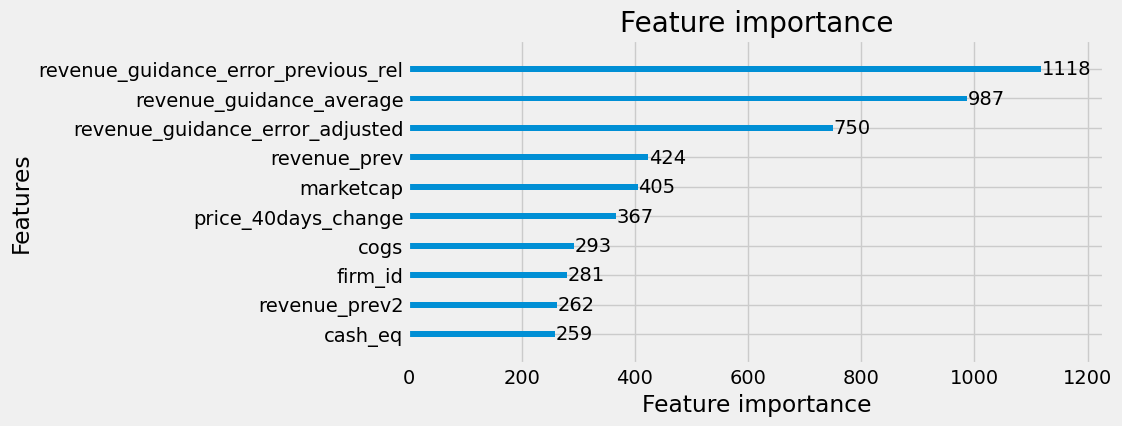

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

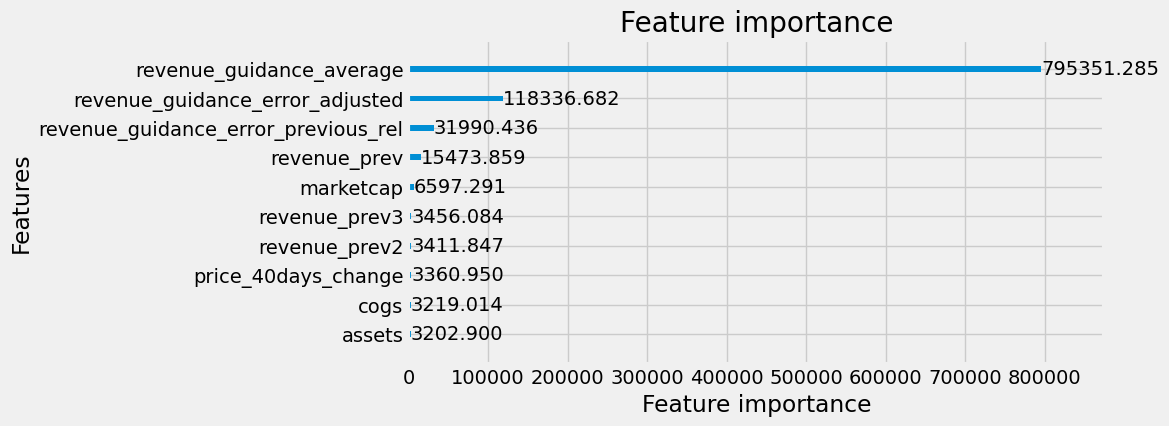

In [81]:
used_features = bst.feature_name()
# print(used_features)

max_feature_to_plot = 10

gain = bst.feature_importance('gain')
featureimp = pd.DataFrame({'feature':bst.feature_name(), 
                   'split':bst.feature_importance('split'), 
                   'relative gain':100 * gain / gain.sum()}).sort_values('split', ascending=False)
featureimp[:max_feature_to_plot]
# print(featureimp["feature"].to_list()[20:])

lightgbm.plot_importance(bst, importance_type="split", max_num_features=max_feature_to_plot, figsize=(8,4))
plt.show()

lightgbm.plot_importance(bst, importance_type="gain", max_num_features=max_feature_to_plot, figsize=(8,4))
plt.show()

# If "split", result contains numbers of times the feature is used in a model (number of times a feature is used to split a node in all used iterations).
# If "gain", result contains total gains of splits which use the feature. In decision tree regression models, feature importance gain is a measure of how much a specific feature contributes to reducing the variance of the target variable when it is used to split the tree. 

## ensemble model

In [12]:
## automatic split
indices = range(X.shape[0])
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, shuffle=False)

# manager / analyst error
manager_analyst_accuracy(actual_var="actual_revenue", manager_var="revenue_guidance_average", analyst_var="analyst_mean_guidance_date")
# target encoding
target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)

# model predictions
# lgbm
lightgbm_model(param, num_boost_round=3000, features=X.columns.to_list(), log=False)
mae_model_test = round(mean_absolute_error(y_test, y_pred), 4)
# et
et_model()
mae_et_test = round(mean_absolute_error(y_test, y_pred_et), 4)
# xgb
xgb_model()
mae_xgb_test = round(mean_absolute_error(y_test, y_pred_xgb), 4)
# rf
rf_model()
mae_rf_test = round(mean_absolute_error(y_test, y_pred_rf), 4)

# sort models by MAE
df_models = pd.DataFrame({"model": ["lgbm", "et", "xgb", "rf"], "MAE": [mae_model_test, mae_et_test, mae_xgb_test, mae_rf_test]})
df_models = df_models.sort_values(by=["MAE"])

# take a simple weighted average
ensemble_weights = {'weight_model1': 0.58, 'weight_model2': 0.37, 'weight_model3': 0.05, 'weight_model4': 0.0}
y_pred_avg = ensemble_weights["weight_model1"]*y_pred + ensemble_weights["weight_model2"]*y_pred_et + ensemble_weights["weight_model3"]*y_pred_xgb + ensemble_weights["weight_model4"]*y_pred_rf
mae_avg_test = round(mean_absolute_error(y_test, y_pred_avg), 4)

# add to df
df_models = pd.concat([df_models, pd.DataFrame({"model": ["ensemble"], "MAE": mae_avg_test})], axis=0).sort_values(by=["MAE"])
df_models

model_performance(y_pred=y_pred_avg, print_results=True)

,model,MAE
0,ensemble,16.7055
0,lgbm,16.8605
1,et,17.7535
3,rf,18.1225
2,xgb,18.2752



**********
model test MAE (RMSE): 16.7055 (43.5139)
manager test MAE (RMSE): 20.1425 (57.3094)
analyst test MAE (RMSE): 35.7537 (104.7162)

**********
model vs manager: edge -0.171 | t-stat -3.243 p-value 0.001
model vs analyst: edge -0.533 | t-stat -11.331 p-value 0.0

************************************


# time series split

In [13]:
# create results dict
results_dict = {} 
results_vars_names = ["fold", "features", "t_model_manager", "p_model_manager", "t_model_analyst", "p_model_analyst", "mae_model_test", "mae_manager_test", "mae_analyst_test", "indices_train_start", "indices_train_end", "indices_test_start", "indices_test_end"] #, "rmse_model_test", "rmse_manager_test", "rmse_analyst_test"
for i in results_vars_names:
    results_dict[i] = []

# time series splits
tss = TimeSeriesSplit(n_splits=5)
for fold, (indices_train, indices_test) in enumerate(tss.split(X)):
    print(f"Fold: {fold}")
    # print("train indices:", indices_train)
    # print("test indices:", indices_test)
    X_train, X_test = X.iloc[indices_train], X.iloc[indices_test]
    y_train, y_test = y.iloc[indices_train], y.iloc[indices_test]
    # print(f"complete: {X.shape} train: {X_train.shape} test: {X_test.shape}")

    # target encoding
    target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)
    # manager / analyst error
    manager_analyst_accuracy(actual_var="actual_revenue", manager_var="revenue_guidance_average", analyst_var="analyst_mean_guidance_date")
    # model 
    lightgbm_model(param, num_boost_round=3000, features=X.columns.to_list(), log=False) # param_opt for most recent optuna params
    model_performance(y_pred=y_pred, print_results=False)

    # results
    results_vars = [fold, X_test.shape[1], round(ttest_model_manager[0], 3), round(ttest_model_manager[1], 3), round(ttest_model_analyst[0], 3), round(ttest_model_analyst[1], 3), mae_model_test, mae_manager_test, mae_analyst_test, indices_train[0], indices_train[-1], indices_test[0], indices_test[-1]] #, rmse_model_test, rmse_manager_test, rmse_analyst_test
    for index, value in enumerate(results_vars_names): # append results to dict
        results_dict[value].append(results_vars[index])

# df with results for each fold
df_tss = pd.DataFrame(results_dict)
df_tss
# average accuracy of all folds
df_tss[["mae_model_test", "mae_manager_test", "mae_analyst_test"]].mean() # MAE
# df_tss[["rmse_model_test", "rmse_manager_test", "rmse_analyst_test"]].mean() # RMSE

df_tss_list = df_tss[["mae_model_test", "mae_manager_test", "mae_analyst_test"]].mean().to_list() # MAE edge
print(f"MAE edge: manager {round((df_tss_list[0] - df_tss_list[1]) / df_tss_list[1], 4)} | analyst {round((df_tss_list[0] - df_tss_list[2]) / df_tss_list[2], 4)}")

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


,fold,features,t_model_manager,p_model_manager,t_model_analyst,p_model_analyst,mae_model_test,mae_manager_test,mae_analyst_test,indices_train_start,indices_train_end,indices_test_start,indices_test_end
0,0,25,-1.679,0.093,-7.558,0.0,14.3251,16.8916,26.1386,0,3332,3333,6665
1,1,25,-2.035,0.042,-4.539,0.0,15.6880,19.6798,24.7910,0,6665,6666,9998
2,2,25,-1.440,0.150,-5.145,0.0,15.6765,17.5814,22.8661,0,9998,9999,13331
3,3,25,-2.054,0.040,-7.571,0.0,18.3420,21.3941,31.6816,0,13331,13332,16664
4,4,25,-2.053,0.040,-9.696,0.0,16.2350,18.5336,34.5040,0,16664,16665,19997


mae_model_test      16.05332
mae_manager_test    18.81610
mae_analyst_test    27.99626
dtype: float64

MAE edge: manager -0.1468 | analyst -0.4266


## plot timeseriessplit

Fold: 0
TRAIN indices: [   0    1    2 ... 2665 2666 2667] 
 TEST indices: [2668 2669 2670 ... 5331 5332 5333]
Fold: 1
TRAIN indices: [   0    1    2 ... 5331 5332 5333] 
 TEST indices: [5334 5335 5336 ... 7997 7998 7999]
Fold: 2
TRAIN indices: [   0    1    2 ... 7997 7998 7999] 
 TEST indices: [ 8000  8001  8002 ... 10663 10664 10665]
Fold: 3
TRAIN indices: [    0     1     2 ... 10663 10664 10665] 
 TEST indices: [10666 10667 10668 ... 13329 13330 13331]
Fold: 4
TRAIN indices: [    0     1     2 ... 13329 13330 13331] 
 TEST indices: [13332 13333 13334 ... 15995 15996 15997]


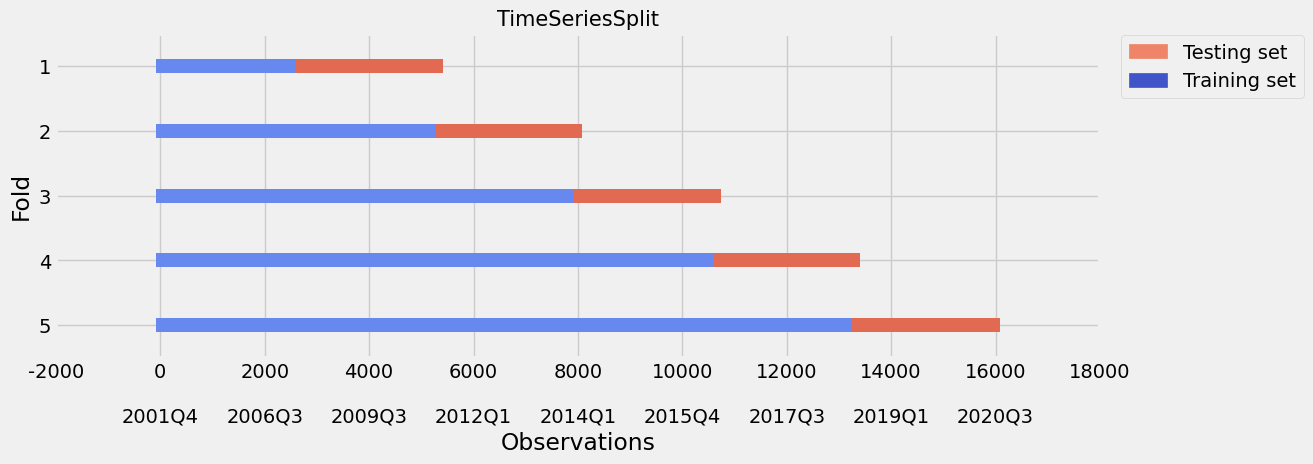

In [23]:
from matplotlib.patches import Patch
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

# Create a sample plot for indices of a cross-validation object
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    
    fig, ax = plt.subplots(1, 1, figsize = (12, 4)) # graph size
    
    # Generate the training/testing visualizations for each CV split
    for fold, (train_index, test_index) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[test_index] = 1
        indices[train_index] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [fold + 0] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-0.2, vmax=1.2)

    # Formatting
    yticklabels = [i+1 for i in range(5)]
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        try:
            tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "] # get_xticks is sometimes larger than the last used index
        except:
            tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-2])].astype(str).tolist() + date_col.iloc[-1:, ].astype(str).tolist() + [" "] 

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels,
           xlabel='Observations', ylabel="Fold",
           ylim=[n_splits-0.5, -.5]) # lower/upper limit of y-axis
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

# print indices
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

plot_cv_indices(tss, 5, X, y, date_col = df['quarter_guided']) #, date_col = df['quarter_guided']

# tss ensemble

In [47]:
#tss predictions
# create empty dict to store prediction arrays for each fold and model
tss_blend_preds = {"y_tests": [], "y_manager": [], "y_analyst": [], "y_preds_lgbm": [], "y_preds_xgb": [], "y_preds_et": [], "y_preds_rf": []}

# time series splits
folds = 5
tss = TimeSeriesSplit(n_splits=folds)
for fold, (indices_train, indices_test) in enumerate(tss.split(X)):
    print(f"Fold: {fold}")
    X_train, X_test = X.iloc[indices_train], X.iloc[indices_test]
    y_train, y_test = y.iloc[indices_train], y.iloc[indices_test]

    # manager / analyst error
    manager_analyst_accuracy(actual_var="actual_revenue", manager_var="revenue_guidance_average", analyst_var="analyst_mean_guidance_date")
    # append array of actual values, manager estimates, analyst estimates
    tss_blend_preds["y_tests"].append(y_test)
    tss_blend_preds["y_manager"].append(X_manager_test)
    tss_blend_preds["y_analyst"].append(X_analyst_test)

    # target encoding
    target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)

    # model predictions for each fold
    # lgbm
    lightgbm_model(param, num_boost_round=3000, features=X.columns.to_list(), log=False)
    tss_blend_preds["y_preds_lgbm"].append(y_pred)
    # et
    et_model()
    tss_blend_preds["y_preds_et"].append(y_pred_et)
    # xgb
    xgb_model()
    tss_blend_preds["y_preds_xgb"].append(y_pred_xgb)
    # rf
    rf_model()
    tss_blend_preds["y_preds_rf"].append(y_pred_rf)

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [48]:
#tss ensemble results

# create dict with arrays of actual/manager/analyst/models
# blend_results_dict = {}
# for mae_model in [key.split("_")[-1] for key, value in tss_blend_preds.items()][1:]:
#     blend_results_dict["mae_test_" + mae_model] = []
# blend_results_dict.update({"mae_test_ensemble": []})

blend_results_dict = {'mae_test_manager': [], 'mae_test_analyst': [], 'mae_test_ensemble': [], 'mae_test_lgbm': [], 'mae_test_et': [], 'mae_test_xgb': [], 'mae_test_rf': [], 'p_manager_ensemble': [], 'p_manager_lgbm': [], 'p_manager_et': [], 'p_manager_xgb': [], 'p_manager_rf': [], 'p_analyst_ensemble': [], 'p_analyst_lgbm': [], 'p_analyst_et': [], 'p_analyst_xgb': [], 'p_analyst_rf': []}

ensemble_weights = {'weight_model1': 0.58, 'weight_model2': 0.37, 'weight_model3': 0.05, 'weight_model4': 0.0} # manager; optuna see cell below

# iterate through folds
for fold in range(0, folds):
    ## calc mae for the ensemble model
    # ensemble new predictions based on weighted average of the 4 models
    y_pred_ensemble = ensemble_weights["weight_model1"]*tss_blend_preds["y_preds_lgbm"][fold] + ensemble_weights["weight_model2"]*tss_blend_preds["y_preds_et"][fold] + ensemble_weights["weight_model3"]*tss_blend_preds["y_preds_xgb"][fold] + ensemble_weights["weight_model4"]*tss_blend_preds["y_preds_rf"][fold] # take a simple weighted average
    mae_ensemble = round(mean_absolute_error(tss_blend_preds["y_tests"][fold], y_pred_ensemble), 4)

    blend_results_dict["mae_test_ensemble"].append(mae_ensemble)
    # calc ensemble p values
    p_manager = round(stats.ttest_ind(a=np.array(abs(y_pred_ensemble-tss_blend_preds["y_tests"][fold])), b=np.array(abs(tss_blend_preds["y_manager"][fold]-tss_blend_preds["y_tests"][fold])), equal_var=False)[1], 4)
    blend_results_dict["p_manager_ensemble"].append(p_manager)
    p_analyst = round(stats.ttest_ind(a=np.array(abs(y_pred_ensemble-tss_blend_preds["y_tests"][fold])), b=np.array(abs(tss_blend_preds["y_analyst"][fold]-tss_blend_preds["y_tests"][fold])), equal_var=False)[1], 4)
    blend_results_dict["p_analyst_ensemble"].append(p_analyst)

    # calc mae for manager/analyst/models
    for key, value in tss_blend_preds.items():
        if "tests" in key: # skip actual values key
            continue
        elif key.__contains__("manager") or key.__contains__("analyst"): # dont calc p value for manager/analyst arrays
            # calc mae for manager/analyst/models
            mae = round(mean_absolute_error(tss_blend_preds["y_tests"][fold], value[fold]), 4)
            # append mae
            key_blend_results_dict = "mae_test_" + key.split("_")[-1]
            blend_results_dict[key_blend_results_dict].append(mae)
        else: # calc mae and p value for each model
            # calc mae
            key_mae_model= "mae_test_" + key.split("_")[-1]
            mae = round(mean_absolute_error(tss_blend_preds["y_tests"][fold], value[fold]), 4)
            blend_results_dict[key_mae_model].append(mae) # append mae
            # calc p manager (of whether MAE of model is significantly different than MAE of manager/analyst)
            key_p_manager = "p_manager_" + key.split("_")[-1] # match key in dict
            p_manager = round(stats.ttest_ind(a=np.array(abs(value[fold]-tss_blend_preds["y_tests"][fold])), b=np.array(abs(tss_blend_preds["y_manager"][fold]-tss_blend_preds["y_tests"][fold])), equal_var=False)[1], 4)
            blend_results_dict[key_p_manager].append(p_manager) # append mae
            # calc p analyst
            key_p_analyst = "p_analyst_" + key.split("_")[-1] # match key in dict
            p_analyst = round(stats.ttest_ind(a=np.array(abs(value[fold]-tss_blend_preds["y_tests"][fold])), b=np.array(abs(tss_blend_preds["y_analyst"][fold]-tss_blend_preds["y_tests"][fold])), equal_var=False)[1], 4)
            blend_results_dict[key_p_analyst].append(p_analyst) # append mae

df_tss_blend = pd.DataFrame(blend_results_dict)
df_tss_blend.loc['mean'] = df_tss_blend.mean() # add mean to each col
df_tss_blend

(df_tss_blend["mae_test_ensemble"].mean() - df_tss_blend["mae_test_manager"].mean()) / df_tss_blend["mae_test_manager"].mean()
(df_tss_blend["mae_test_ensemble"].mean() - df_tss_blend["mae_test_analyst"].mean()) / df_tss_blend["mae_test_analyst"].mean()

,mae_test_manager,mae_test_analyst,mae_test_ensemble,mae_test_lgbm,mae_test_et,mae_test_xgb,mae_test_rf,p_manager_ensemble,p_manager_lgbm,p_manager_et,p_manager_xgb,p_manager_rf,p_analyst_ensemble,p_analyst_lgbm,p_analyst_et,p_analyst_xgb,p_analyst_rf
0,15.4122,26.02540,13.28060,13.32390,14.74110,14.74390,14.34450,0.08490,0.09290,0.59520,0.59860,0.4039,0.0,0.00000,0.0,0.00000,0.00000
1,19.0932,24.49210,14.50030,15.58910,14.93810,16.90060,16.50290,0.03890,0.12780,0.05580,0.33070,0.2523,0.0,0.00010,0.0,0.00090,0.00050
2,18.9865,24.60470,13.95160,14.53740,15.28800,16.10670,16.50230,0.00840,0.02110,0.05660,0.13910,0.2153,0.0,0.00000,0.0,0.00000,0.00010
3,17.8383,22.83550,14.79420,15.63660,14.83990,17.79080,16.49680,0.03110,0.12750,0.03020,0.97420,0.3606,0.0,0.00000,0.0,0.00130,0.00000
4,19.6958,29.10050,15.95260,16.09030,17.17520,17.96170,17.93160,0.01640,0.02060,0.11660,0.27320,0.2839,0.0,0.00000,0.0,0.00000,0.00000
mean,18.2052,25.41164,14.49586,15.03546,15.39646,16.70074,16.35562,0.03594,0.07798,0.17088,0.46316,0.3032,0.0,0.00002,0.0,0.00044,0.00012


-0.20375167534550562

-0.42955826542482084

## ensemble optuna

In [25]:
# minimize the average MAE of the ensemble model over all folds by adjusting the weights of the model's components
def objective_blend(trial):
    weight_model1 = trial.suggest_float('weight_model1', 0.5, 1, step=0.01)
    weight_model2 = trial.suggest_float('weight_model2', 0, (1 - weight_model1), step=0.01)
    weight_model3 = trial.suggest_float('weight_model3', 0, (1 - weight_model1 - weight_model2), step=0.01)
    weight_model4 = (1-weight_model1-weight_model2-weight_model3)

    blend_results_dict = {'mae_test_manager': [], 'mae_test_analyst': [], 'mae_test_ensemble': [], 'mae_test_lgbm': [], 'mae_test_et': [], 'mae_test_xgb': [], 'mae_test_rf': []}

    ensemble_weights = {'weight_model1': weight_model1, 'weight_model2': weight_model2, 'weight_model3': weight_model3, 'weight_model4': weight_model4}

    # iterate through folds
    for fold in range(0, folds):
        # if fold in [1, 2,4]:
        #     continue
        # calc mae for the ensemble model
        y_pred_ensemble = ensemble_weights["weight_model1"]*tss_blend_preds["y_preds_lgbm"][fold] + ensemble_weights["weight_model2"]*tss_blend_preds["y_preds_et"][fold] + ensemble_weights["weight_model3"]*tss_blend_preds["y_preds_xgb"][fold] + ensemble_weights["weight_model4"]*tss_blend_preds["y_preds_rf"][fold] # take a simple weighted average
        mae_ensemble = round(mean_absolute_error(tss_blend_preds["y_tests"][fold], y_pred_ensemble), 4)
        blend_results_dict["mae_test_ensemble"].append(mae_ensemble)

        # calc mae for manager/analyst/models
        for key, value in tss_blend_preds.items():
            if "tests" in key: # skip actual values key
                continue
            else: # add prediction array of each model for the consecutive models
                # calc mae for manager/analyst/models
                mae = round(mean_absolute_error(tss_blend_preds["y_tests"][fold], value[fold]), 4)
                # append mae
                key_blend_results_dict = "mae_test_" + key.split("_")[-1]
                blend_results_dict[key_blend_results_dict].append(mae)
        
            
    df_tss_blend = pd.DataFrame(blend_results_dict)
    return df_tss_blend["mae_test_ensemble"].mean()
 
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_blend = optuna.create_study(direction='minimize')
study_blend.optimize(objective_blend, n_trials=300)

blend_dict_opt = study_blend.best_trial.params
blend_dict_opt["weight_model4"] = round((1-blend_dict_opt["weight_model1"]-blend_dict_opt["weight_model2"]-blend_dict_opt["weight_model3"]),2)
 
print('Number of finished trials:', len(study_blend.trials))
print(f'Best trial: #{study_blend.best_trial.number} {study_blend.best_trial.values[0]}', blend_dict_opt)

Number of finished trials: 300
Best trial: #204 15.509559999999999 {'weight_model1': 0.54, 'weight_model2': 0.41000000000000003, 'weight_model3': 0.04, 'weight_model4': 0.01}


# firm prediction

In [19]:
## sample restrictions
df = df_raw.copy()

# drop revenues >90% percentile
df = df[
    (df["actual_revenue"] >= df["actual_revenue"].quantile(.90)) & 
    (df["actual_revenue"] < 49360.0)
    ] # 49360.0: highest msft
    
# df = df.iloc[:(int(df.shape[0]*0.8)), ]
df = df.reset_index(drop=True)

y = df["actual_revenue"] # dependent variable
forecast_feature = ["revenue_guidance_average", "revenue_guidance_error_adjusted", "revenue_guidance_range", "revenue_guidance_error_previous_rel"]
floats = boruta_feats_manager[:21]
categoricals_targetencode = ['quarter_fama_industry_cat', "quarter_previous_cat"]
categoricals = ["firm_id"]

features = forecast_feature + floats + categoricals_targetencode + categoricals
X = df[pd.unique(features).tolist()].copy() # drop duplicate features

## automatic split
indices = range(X.shape[0])
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, shuffle=False)
## target encoding
target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)
## train model
lightgbm_model(param, num_boost_round=3000, features=X.columns.to_list())



# overwrite test with specific firm
df_firm = df[df["isin"] == "US5949181045"]
df_firm_year = df_firm[df_firm["quarter_guided"].dt.year >= 2020]

# overwrite X and y test
y_test = df_firm_year["actual_revenue"] # dependent variable

forecast_feature = ["revenue_guidance_average", "revenue_guidance_error_adjusted", "revenue_guidance_range", "revenue_guidance_error_previous_rel"]
floats = boruta_feats_manager[:21]
categoricals_targetencode = ['quarter_fama_industry_cat', "quarter_previous_cat"]
categoricals = ["firm_id"]

features = forecast_feature + floats + categoricals_targetencode + categoricals
X_test = df_firm_year[pd.unique(features).tolist()].copy() # drop duplicate features

target_encoding(cat_columns=categoricals_targetencode, shrinking_factor=0.0)

# run model
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
et_model()
xgb_model()
rf_model()

ensemble_weights = {'weight_model1': 0.58, 'weight_model2': 0.37, 'weight_model3': 0.05, 'weight_model4': 0.0}
y_pred_avg_firm = ensemble_weights["weight_model1"]*y_pred + ensemble_weights["weight_model2"]*y_pred_et + ensemble_weights["weight_model3"]*y_pred_xgb + ensemble_weights["weight_model4"]*y_pred_rf

# results
df_single = df_firm_year[["actual_revenue", "revenue_guidance_average"]].reset_index()
df_single = pd.concat([df_single, pd.DataFrame({"y_pred_lgbm": y_pred, "y_pred_avg": y_pred_avg_firm})], axis=1)
df_single["error_manager"] = np.abs(df_single["actual_revenue"] / df_single["revenue_guidance_average"] - 1)
df_single["error_lgbm"] = np.abs(df_single["actual_revenue"] / df_single["y_pred_lgbm"] - 1)
df_single["error_ensemble"] = np.abs(df_single["actual_revenue"] / df_single["y_pred_avg"] - 1)
df_single["delta_manager_lgbm"] = df_single["error_lgbm"] / df_single["error_manager"] - 1
df_single

df_single["delta_manager_lgbm"].mean()

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's l1: 258.083
Evaluated only: l1


,index,actual_revenue,revenue_guidance_average,y_pred_lgbm,y_pred_avg,error_manager,error_lgbm,error_ensemble,delta_manager_lgbm
0,1676,35021.0,34500.0,35298.772132,35209.282265,0.015101,0.007869,0.005348,-0.478913
1,1714,38033.0,36325.0,38224.244392,38275.522837,0.047020,0.005003,0.006336,-0.893594
2,1749,37154.0,35600.0,36996.603310,36898.346625,0.043652,0.004254,0.006929,-0.902539
3,1792,43076.0,39950.0,43229.144300,42519.445581,0.078248,0.003543,0.013089,-0.954726
4,1839,41706.0,40800.0,43175.852094,42675.887544,0.022206,0.034043,0.022727,0.533080
5,1890,46152.0,44050.0,44172.990898,44009.838187,0.047719,0.044801,0.048675,-0.061133
6,1944,45317.0,43750.0,44375.648625,44151.857668,0.035817,0.021213,0.026389,-0.407735


-0.45222269015021066